# Balancer AMM Token Pool Model & Simulations

# The LP package

Introduction on the context and motivation to build and open-source this model (perhaps could go below to further links)

This is a model and set of simulations to analyse Balancer AMM pools from a liquidity provider point of view,  
using **historical on-chain data**.

You'll be able to analyse **pool share value** in the following scenarios:  
- C1 Analyse **pool share value over time** (incl. Impermanent Loss)  
- C2 Analyse pool share value **when add** (incl. slippage)
- C3 Analyse pool share value **when exit** (incl. slippage)

## Table of content
here List and links to content (automatically?)

# A. System Context

### Value Drivers & Key Variables
Differential Syntax Diagram goes here

## Naming Convention

todo: replace img with table

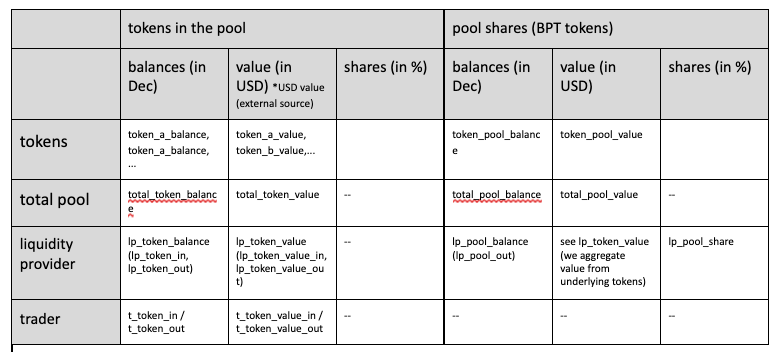

## List of State Variables  

pool = 

## List of Parameters

In [1]:
swap_fee = [0.1]

### System Mapping (Differential spec here? Or in later specifying simulations)
Show the (digital twin!) system in a viz language like
- Conceptual model
- Causal Loop
- Stock & Flow
...or several of them, tbd

### Mathematical Specification (Policy here? Or in later specifying simulations)
shows the Balancer AMM math (or provides a link),
add some more context, particularly
- what function is used where (reference to What-if-Matrix, perhaps add eg. "Spotprice" to What-if-Matrix) this reference of Math > Simulation would be ideal

### System Design (see above)
Show the (digital twin!) system in
- Differential Spec Syntax

# B. cadCAD Notebook

### 0. Dependencies
optionally add context to code below, and link "requirements.txt" 

In [2]:
import pandas as pd 
 

# C. Simulate: 
# Change of LP pool share value over time

### C1.1 Scenario

This simulation allows you to analyse the change of a liquidity provider’s pool share value over time.  
You can run various scenarios  
a) step into the shoes of a specific liquidity provider (should be the first transaction in your data set) and simulate your returns, potential losses or optimization strategies “what if I were this person” (100% overlap with on-chain data)  
b) define a new liquidity add (make artificial “JOIN” event, which didn’t exist in on-chain), and simulate your returns, potential losses or optimization strategies (based on on-chain transactions, deviations according to your liquidity add)  

### C1.2 State Variables


Define token symbol for better readability:

In [3]:
#code to assign token symbol to transaction data (token smart contracts) 

Pull initial balances from data: (how to data parse in readme.file in data folder)

In [4]:
# Date/block timestampStart
# Date/block timestampStop

from model.genesis_states import *
import pprint

pool = initial_values['pool']
pp = pprint.PrettyPrinter(indent=4)

print('## State Variables')
pp.pprint(pool)



## State Variables
{   'generated_fees': 0.0,
    'pool_shares': 100.0,
    'tokens': {   'DAI': {   'balance': 10000000,
                             'bound': True,
                             'denorm_weight': 10,
                             'weight': 20},
                  'WETH': {   'balance': 67738.6361731024,
                              'bound': True,
                              'denorm_weight': 40,
                              'weight': 80}}}


### C1.3 System Parameters
(provides an overview on all parameters)

The system parameters we need to **define** for simulating this use case are:
- parameter description in human langage / parameter (code) / with value (code)

The following system parameters will be **swept** in the simulation:
- parameter description in human language / parameter (code) / values to sweep (code)



In [5]:
from model.config import parameters

pp.pprint(parameters)

{'swap_fee': [0.1]}


### C1.4 State Update Functions

Balancer Math implementation in python in file [balancer_math](./model/parts/balancer_math.py)

In regard to this simulation there are 3 types of action the users can do:

#### Add liquidity (join pool)

Transfer tokens into the pool proportionally to the tokens weights in it, and receive an amount of pool share tokens that represent the user's position that the pool will mint, adding to the total_pool_shares.

Balancer allows to add liqudity in 2 ways

- `s_join_pool`: Defining the amount of pool_share tokens the user wants out. This will calculate the amount of each token bound to the pool that will be pulled from the user's wallet, in proportion to the bound tokens weight in the pool.

- `s_join_swap_extern_amount_in`: Sending a determinate amount of 1 of the bound tokens. The amount of pool_share tokens out will be calculated and returned to the user. This operation acts like a swap as well, so swap_fees will be aplied.



#### Remove liquidity (exit pool)

Transfer tokens out from the pool to the user's ballance, proportionally to the tokens weights in it, sending the corresponding pool_share tokens back to the pull, which will burn them reducing total_pool_shares

Balancer allows to remove liqudity in 2 ways

- `s_exit_pool`: Defining the amount of pool_share tokens the user send to the pool and burn. This will calculate the amount of each token bound to the pool that will be sent to the user's wallet, in proportion to the bound tokens weight in the pool.

- `s_exit_swap_pool_amount_in`: Reclaiming a determinate amount of 1 of the bound tokens. The amount of pool_share tokens needed to reclaim this amount will be calculated and pulled from the user's balance and burnt. This operation acts like a swap as well, so swap_fees will be aplied.


#### Swap tokens (exchange one token for another)

- `s_swap_exact_amount_in`: Send one token to the pool, defining which token the user wants in return.



#### Simplifications in the model

Balancer has 2 variants of each method, one where you fix the amount of tokens in and the amount and a limit on the amount of tokens out or swap price, and one fixing the amount of tokens out and limits on the swap price or amount of tokens in.

The reason to this is that in Ethereum transactions can get mined before the one sent by the user, so pool state can change before the transaction is executed, resulting in trades not benefitial for the user. 

For this, the pool methods will check the user define limits and will make the transaction fail if is not within the user defined bounds. This way gas will be spent and lost, but unfavorable trades will not be made.

Since our simulation deals with sequential transactions, *this logic is not included and all methods will use math for known token amount in.*





Defined in [pool_state_updates.py](./model/parts/pool_state_updates.py)

### C1.5 Partial State Update Blocks


1. Parse action and update pool
2. Update external prices
3. Calculate metrics

The BPool smart contract logic is split in 2, the state update blocks 1 (apply BMath to update pool state) and 3 (use BMath to `get_spot_price` of the tokens after the trades, which is a system metric)



Defined in [partial_state_update_block.py](./model/partial_state_update_block.py)

In [6]:
from model.partial_state_update_block import *

pp.pprint(partial_state_update_block)

[   {   'policies': {   'user_action': <function p_action_decoder at 0x7fd1b0027160>},
        'variables': {'pool': <function s_update_pool at 0x7fd1aeb95ca0>}}]


### C1.6 Configuration




In [7]:
from model.config import sim_config

pp.pprint(sim_config)


[{'M': {'swap_fee': 0.1}, 'N': 1, 'T': range(0, 2490)}]


### C1.7 Execution

In [8]:
from model.sim_runner import *

df = run()



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (2490, 1, 1, 1)
Execution Method: single_proc_exec
Execution Mode: single_threaded
Total execution time: 0.19s


### C1.8 Simulation Output Preparation

In [18]:
df.head()


,pool,simulation,subset,run,substep,timestep
0,"{'tokens': {'DAI': {'weight': 20, 'denorm_weig...",0,0,1,0,0
1,"{'tokens': {'DAI': {'weight': 20, 'denorm_weig...",0,0,1,1,1
2,"{'tokens': {'DAI': {'weight': 20, 'denorm_weig...",0,0,1,1,2
3,"{'tokens': {'DAI': {'weight': 20, 'denorm_weig...",0,0,1,1,3
4,"{'tokens': {'DAI': {'weight': 20, 'denorm_weig...",0,0,1,1,4


### C1.9 Simulation Outcome & Conclusion

notes on the diagram:  

general information design
- all blue lines = USD values
- all yellow lines = number of tokens  
and chart:


and conclusions:

In [9]:
# dummy data dictionary
data = {'total_pool_balance': [6.1,5.8,5.7,5.7,5.8,5.6,5.5,5.3,5.2,5.2],
        'total_token_value': [1500,1520,1525,1523,1515,1540,1545,1560,1555,1565], 'blockno': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
       }

# create data frame (here from dictionary)
simresult = pd.DataFrame(data,columns=['blockno', 'total_token_value','total_pool_balance'])

#print table (just to check)
print (simresult)

   blockno  total_token_value  total_pool_balance
0       50               1500                 6.1
1       51               1520                 5.8
2       52               1525                 5.7
3       53               1523                 5.7
4       54               1515                 5.8
5       55               1540                 5.6
6       56               1545                 5.5
7       57               1560                 5.3
8       58               1555                 5.2
9       59               1565                 5.2


<AxesSubplot:xlabel='blockno'>

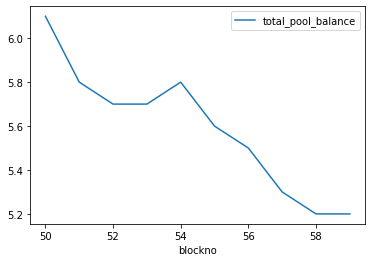

In [10]:
#plot chart
simresult.plot(x ='blockno', y='total_pool_balance', kind = 'line')	

-------------------------
all further simulations C2 + C3 go here
--------------

# System Validation and Limitations

- document the steps taken to validate if the model reflects real Balancer AMM properly (Did we build the right model?)
- document the steps taken to verify if the model creates reliable results (Did we build the model right?)

### Notes (Draft!)
**a) BMath Calculations:**  
Our goal is to implement the BMath calculations in this Python model in a way that it replicates *exactly* the calculation results in an EVM.

We've verified the model with a series of tests:
- create tests using balancer's smart contract repos
- generate a pool contract in a local EVM, do a swap or whatever operation, 
- put those input outputs as a test in python, port the code, test to see if the results match

**b) external USD price feed** 
- in this simulation we're using historical USD prices from xxx (source)  
- to map blocks and transactions we've ... (how we parsed USD price feed)

**c) Our simulation does not include:**  
- gas prices or add_fees when adding liquidity  
- 

**Results: (summarize)**

(Notes for ourselves:
- assertAlmostEqual takes 7 decimal places for comparision, sometimes we had to set 5 decimal places for the test to pass
- we could publish the EVM tests  as companion in the docs later but right now is very rough code
- to run the test go to your virtual env, instlal requirements with pip, then run pytest
- they should pass
- when everything is tested and works as the contracts, we could move on to cadCAD stuff

According to Balancer.finance documentation "The formulas are sufficient to describe the functional specification, but they are not straightforward to implement for the EVM, in part due to a lack of mature fixed-point math libraries." (https://docs.balancer.finance/core-concepts/protocol/index))

# E. Comments

closing comments if appropriate, and links to other notebooks/other use cases